In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io as io
import cv2

In [2]:
# Directories containing images
dataDir = 'images'
annDir = 'val'
fileLabel = 'ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt'
fileLabelNames = 'labelNames.txt'
fileImageNetNames = 'ImageNetLabels.txt'

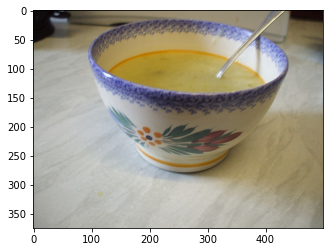

In [3]:
fileName = 'ILSVRC2012_val_00000004.JPEG'
I = io.imread( '%s/%s'%(dataDir,fileName) )

plt.imshow(I)
plt.show()

In [4]:
IMG_SIZE = [ 224, 224 ]
image = I
image = tf.image.resize( image, IMG_SIZE )
image /= 255
image = image.numpy()   # Bring back to np.array

In [142]:
def createPyramid( image, sig_o ):

    pyramid = []
    sig = sig_o
    curImage = image

    # Uses 4 levels of a pyramid
    for _ in range(5):

        prevImage = curImage
        height, width, _ = tf.shape( curImage )
        print( tf.shape( curImage ))
        # Gaussian Pyramid
        # Apply blur and downsample
        #curImage = applyGauss( curImage, sig )
        curImage = cv2.pyrDown( curImage, dstsize=(height//2, width//2)  )

        # Laplacian Pyramid
        # Upsample the blurred image and compute the difference
        resizedImage = cv2.pyrUp( curImage, dstsize=(height, width) )
        pyramid.append( prevImage - resizedImage )

        sig = sig*2

    # Append top of pyramid
    pyramid.append( curImage )

    return pyramid

def applyGauss( image, sig ):

    # Apply Gaussian blur
    ksize = (0,0)   # Kernel size is computed from sig values
    sigX = sig
    sigY = sigX     # sigY uses sigX
    image = cv2.GaussianBlur( image, ksize, sigX, sigY )

    return image

In [101]:
def expWeight( laplacePyramid, u_o, v_o, f_o ):

    # Ensure center is an int
    u_o = tf.cast( np.ceil(u_o), tf.int32 )
    v_o = tf.cast( np.ceil(v_o), tf.int32 )

    # Get ratios to use for each level
    height, width, _ = tf.shape( laplacePyramid[0] )
    u_o = tf.cast( u_o/height, tf.float32 )
    v_o = tf.cast( v_o/width, tf.float32 )

    pyramid = []

    for k in range( len(laplacePyramid) ):

        height, width, _ = tf.shape( laplacePyramid[k] )
        height = tf.cast( height, tf.float32 )
        width = tf.cast( width, tf.float32 )

        # Ensure center is an int
        u_cur = np.ceil(u_o * height)
        v_cur = np.ceil(v_o * width)

        # Generate coordinates centered at (u_o, v_o) for each level
        u_front = tf.reverse( tf.range( 1, u_cur ), axis=[-1] )
        u_back = tf.range( height-u_cur+1 )
        v_front = tf.reverse( tf.range( 1, v_cur ), axis=[-1] )
        v_back = tf.range( width-v_cur+1 )
        u = tf.concat( [ u_front, u_back ], axis=-1 )
        v = tf.concat( [ v_front, v_back ], axis=-1 )

        # Create a matrix of coordinates
        v = np.expand_dims( v, axis=-1 )            # For broadcasting
        coords = tf.math.pow(u,2) + tf.math.pow(v,2)

        # Create the foveal size for each level
        f_k = tf.math.pow(2,k) * f_o
        f_k = tf.cast( f_k, tf.float32 )

        # Get the kernel needed to multiply the pyramid
        kernel = tf.exp( -coords / ( 2*tf.math.pow(f_k,2) ) )
        kernel = np.expand_dims( kernel, axis=-1 )  # For broadcasting

        # print( np.max( laplacePyramid[k]*kernel ))
        # print( np.min( laplacePyramid[k]*kernel ) )
        # plt.imshow( laplacePyramid[k]*kernel)
        # plt.show()
        print( tf.shape(kernel) )
        pyramid.append( laplacePyramid[k] * kernel )

    return pyramid

In [162]:
def expWeight( laplacePyramid, u_o, v_o, f_o ):

    # Ensure center is an int
    u_o = tf.cast( np.ceil(u_o), tf.int32 )
    v_o = tf.cast( np.ceil(v_o), tf.int32 )

    # Get ratios to use for each level
    height, width, _ = tf.shape( laplacePyramid[0] )
    # u_o = tf.cast( u_o/height, tf.float32 )
    # v_o = tf.cast( v_o/width, tf.float32 )

    # Generate coordinates centered at (u_o, v_o) for each level
    u_front = tf.reverse( tf.range( 1, u_o ), axis=[-1] )
    u_back = tf.range( height-u_o+1 )
    v_front = tf.reverse( tf.range( 1, v_o ), axis=[-1] )
    v_back = tf.range( width-v_o+1 )
    u = tf.concat( [ u_front, u_back ], axis=-1 )
    v = tf.concat( [ v_front, v_back ], axis=-1 )

    # Create a matrix of coordinates
    v = np.expand_dims( v, axis=-1 )            # For broadcasting
    coords = tf.math.pow(u,2) + tf.math.pow(v,2)
    coords = tf.cast( coords, tf.float32 )
    pyramid = []

    for k in range( len(laplacePyramid) ):

        curHeight, curWidth, _ = tf.shape( laplacePyramid[k] )

        laplacePyramid[k] = cv2.resize( laplacePyramid[k], dsize=( height, width ) )

        # Create the foveal size for each level
        f_k = tf.math.pow(2,k) * f_o
        f_k = tf.cast( f_k, tf.float32 )

        # Get the kernel needed to multiply the pyramid
        kernel = tf.exp( -coords / ( 2*tf.math.pow(f_k,2) ) )
        kernel = kernel / np.max( kernel )
        kernel = np.expand_dims( kernel, axis=-1 )  # For broadcasting

        # print( np.max( laplacePyramid[k]*kernel ))
        # print( np.min( laplacePyramid[k]*kernel ) )
        # plt.imshow( laplacePyramid[k]*kernel)
        # plt.show()
        print( tf.shape(kernel) )
        laplacePyramid[k] = laplacePyramid[k] * kernel
        laplacePyramid[k] = cv2.resize( laplacePyramid[k], dsize=( curHeight, curWidth ) )
        pyramid.append( laplacePyramid[k] )

    return pyramid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tf.Tensor([224 224   3], shape=(3,), dtype=int32)
tf.Tensor([112 112   3], shape=(3,), dtype=int32)
tf.Tensor([56 56  3], shape=(3,), dtype=int32)
tf.Tensor([28 28  3], shape=(3,), dtype=int32)
tf.Tensor([14 14  3], shape=(3,), dtype=int32)
tf.Tensor([224 224   1], shape=(3,), dtype=int32)
tf.Tensor([112 112   1], shape=(3,), dtype=int32)
tf.Tensor([56 56  1], shape=(3,), dtype=int32)
tf.Tensor([28 28  1], shape=(3,), dtype=int32)
tf.Tensor([14 14  1], shape=(3,), dtype=int32)
tf.Tensor([7 7 1], shape=(3,), dtype=int32)
-0.36371356
0.3924254


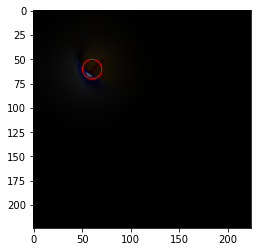

In [163]:
img = image
sig_o = 0.5  # Paper used 1, but this gives similar-looking results
f_o = 10
pyramid = createPyramid( img, sig_o )
centerX = 60
centerY = 60
# print( np.min(pyramid[0]) )
# plt.imshow( pyramid[0]-np.min(pyramid[0]) )
# plt.show()
# print( np.min(pyramid[1]) )
# plt.imshow( pyramid[1] -np.min(pyramid[1]) )
# plt.show()
pyramid = expWeight( pyramid, centerX, centerY, f_o )

# Sum each level of pyramid
# finalImg = np.zeros( tf.shape(pyramid[-1]) )
# finalImg = cv2.pyrDown( finalImg )
# assert( tf.reduce_sum( finalImg ) == 0 )    # Ensure finalImg is all 0's
finalImg = pyramid[-1]
for i in reversed( range( len(pyramid)-1 ) ):
    height, width, _ = tf.shape( pyramid[i] )
    #finalImg = tf.image.resize( finalImg, [height,width] )
    finalImg = cv2.pyrUp( finalImg, dstsize=(height, width) )
    finalImg += pyramid[i]
    #finalImg = cv2.pyrUp( finalImg ) + pyramid[i]

print( np.min(finalImg) )
print( np.max(finalImg) )
# Normalize
# finalImg = finalImg-np.min(finalImg)        # THIS NEEDS TO BE FIXED B/C GIVES WEIRD SCALING
# finalImg = finalImg/np.max(finalImg)

fig, ax = plt.subplots()
plt.imshow( finalImg )
ax.add_patch( patches.Circle( (centerX, centerY), f_o, fill=False, color='r' ) )
plt.show()


# Test Laplace
# finalImg = tf.zeros( tf.shape(pyramid[-1]) ).numpy()
# finalImg = cv2.pyrDown( finalImg )
# # print( finalImg.shape )
# #finalImg = pyramid[-1]
# for i in reversed( range( len(pyramid) ) ):
#     finalImg = cv2.pyrUp( finalImg ) + pyramid[i]
# #print( np.min( finalImg ) )
# plt.imshow(finalImg-np.min(finalImg))
# plt.show()

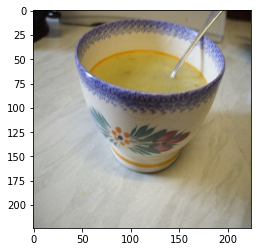

In [128]:
plt.imshow(image)
plt.show()